<a href="https://colab.research.google.com/github/bradbradlin/Machine-Learning-Projects/blob/main/Bert_model_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suspicious email detection by unsupervised learning

Background:

In the financial industry, email monitoring is one of measures to prevent from non compliance activities, for example rogue trading. Traditional monitoring of emails is screening by keywords which is manually maintained. Disadvantages of traditional approach include expensive human involvement and ineffectiveness. To oveecome those disadvantages, machine learning is a better alternative.  

Nowadays, anomaly email detection, such as spam email, mainly adopts supervised algorithms. The pain point of supervised learning is labeled dataset which needs expensive human annotation.  To cope with this issue, this workbook will demonstrate an unsupervised learning technique to predict the probability of suspicious emails. 


### Supervised vs Unsupervised Learning:
Unlike supervised learning, unsupervised learning don't need labeled dataset to train the classifier.

![alt text](https://drive.google.com/uc?id=1Fu4MRSRGNZZaBw_9p-dcFJslhUHzUWUQ)

In [1]:
!pip install transformers
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text
!pip install -q tf-models-official

In [2]:
#Import libraries
import pandas as pd 
import numpy as np
import nltk
import re
import email
import matplotlib.pyplot as plt 
import seaborn as sns 
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import cosine

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from keras.callbacks import EarlyStopping

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import os
import shutil


import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer


tf.get_logger().setLevel('ERROR')

%matplotlib inline
%tensorflow_version 2.x

print(tf.__version__)
nltk.download('punkt')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Found GPU at: /device:GPU:0
2.4.1
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [4]:
%cd /content/gdrive/My Drive/Colab Notebooks/NLP/emails

/content/gdrive/My Drive/Colab Notebooks/NLP/emails


In [5]:
emails = pd.read_csv('./emails/emails.csv',quoting=2,header=0)
emails = emails[emails['file'].str.contains('sent').tolist()]
filelist = emails['file'].tolist()
messages = emails['message'].tolist()
print(messages[0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [6]:
def format_message(text):
    sTemp=text
    location=sTemp.find("---------------------- Forwarded")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("----- Forwarded")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("          ++++++CONFIDENTIALITY NOTICE+++++")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("-----Original Message-----")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find(" -----Original Appointment-----")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("\n\t")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("@")
    if location!=-1:
        sTemp=sTemp[:location]
        sTemp=sTemp[:sTemp.rfind('\n')]
    return sTemp

In [7]:
#Only 10 email adrresses are investigated
filter_list = ['kay.mann@enron.com']
min_words=10
from_list = []
subject_list = []
message_list = []
formatted_list = []

#Import content into Dataframe
for message in messages:
    msg = email.message_from_string(message)
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            from_value = part.get("From")
            if from_value in filter_list:
                sTemp = format_message(part.get_payload())
                sTemp=sTemp.strip()
                if len(sTemp) > 0:
                    totalWords=0
                    sentences=sent_tokenize(sTemp.lower())
                    for sentence in sentences:
                        words=word_tokenize(sentence)
                        totalWords+=len(words)
                    if totalWords>=min_words:
                        from_list.append(part.get("From"))
                        subject_list.append(part.get("Subject"))
                        message_list.append(part.get_payload())
                        formatted_list.append(sTemp)
                    
email_df = pd.DataFrame({'From': from_list, 'Subject': subject_list, 'Message': message_list, 'FormattedMessage': formatted_list,})

In [8]:
print('Size of total dataset: ', email_df.shape[0])
email_df['Body'] = email_df['FormattedMessage']
email_df_copy = email_df['Body'].copy() #Backup the orginal dataset

Size of total dataset:  6355


In [9]:
#Loading anomaly samples
anomaly_df = pd.read_csv('./emails/anomaly.csv', encoding= 'iso-8859-1' , header=0, index_col=False)
anomaly_df_copy = anomaly_df['Body'].copy() #Backup the orginal dataset

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
split = int(len(email_df)/batch_size*0.9)

dataset = tf.data.Dataset.from_tensor_slices(email_df['FormattedMessage'])
dataset = dataset.batch(batch_size).shuffle(seed)

raw_train_ds = dataset.take(split) 
raw_val_ds = dataset.skip(split)

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

def bert_embedding():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  encoder_inputs = preprocess(text_input)
  outputs = bert_encoder(encoder_inputs)
  return tf.keras.Model(text_input, outputs)

def build_model(num_of_encoder, num_of_hidden):

  # input placeholder
  input_encoded = tf.keras.layers.Input(shape=(num_of_encoder,))

  # this is the encoded representation of the input
  encoded = tf.keras.layers.Dense(num_of_hidden*1.5, activation='relu', 
                                  kernel_initializer=tf.keras.initializers.he_normal(seed=None))(input_encoded)

  # this is the encoded representation of the input
  encoded1 = tf.keras.layers.Dense(num_of_hidden, activation='relu')(encoded)

  # this is the encoded representation of the input
  encoded2 = tf.keras.layers.Dense(num_of_hidden*1.5, activation='relu')(encoded1)

  # this is the loss reconstruction of the input
  decoded = tf.keras.layers.Dense(num_of_encoder, activation='tanh')(encoded2)

  return tf.keras.Model(input_encoded, decoded)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1, Total size: 89.58MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'.


In [13]:
model1 = bert_embedding()
train_emb = model1.predict(train_ds)['pooled_output']
val_emb = model1.predict(val_ds)['pooled_output']
test_emb = model1.predict(anomaly_df['Body'])['pooled_output']

In [17]:
no_of_encoder = len(train_emb[1])
no_of_hidden = int(no_of_encoder/2) 
bert_autoencoder = build_model(no_of_encoder, no_of_hidden)

In [18]:
bert_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 384)               196992    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               98560     
_________________________________________________________________
dense_6 (Dense)              (None, 384)               98688     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               197120    
Total params: 591,360
Trainable params: 591,360
Non-trainable params: 0
_________________________________________________________________


In [19]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)
bert_autoencoder.compile(optimizer=opt, loss='mean_squared_error')

bert_autoencoder.fit(train_emb, train_emb, epochs=20, validation_data=(val_emb, val_emb))

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4604 - val_loss: 0.0544
Epoch 2/20
178/178 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0440
Epoch 3/20
178/178 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0399
Epoch 4/20
178/178 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0370
Epoch 5/20
178/178 [==============================] - 0s 3ms/step - loss: 0.0384 - val_loss: 0.0366
Epoch 6/20
178/178 [==============================] - 0s 3ms/step - loss: 0.0371 - val_loss: 0.0389
Epoch 7/20
178/178 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0360
Epoch 8/20
178/178 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0353
Epoch 9/20
178/178 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0375
Epoch 10/20
178/178 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0352

In [20]:
def key_consine_similarity(tupple): 
  return tupple[1] 
def get_computed_similarities(vectors, predicted_vectors, reverse=False): 
  data_size = len(vectors) 
  cosine_similarities = [] 
  for i in range(data_size): 
    cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i])) 
    cosine_similarities.append((i, cosine_sim_val)) 
  return sorted(cosine_similarities, key=key_consine_similarity, reverse=False) 

In [21]:
bert_autoencoder.evaluate(val_emb, val_emb)

21/21 [==============================] - 0s 1ms/step - loss: 0.0343


0.034344226121902466

In [22]:
pred_train_emb = bert_autoencoder.predict(train_emb)
pred_val_emb = bert_autoencoder.predict(val_emb)
pred_test_emb = bert_autoencoder.predict(test_emb)

In [23]:
train_cos_sim = get_computed_similarities(train_emb, pred_train_emb, reverse=False)
val_cos_sim = get_computed_similarities(val_emb, pred_val_emb, reverse=False)
test_cos_sim = get_computed_similarities(test_emb, pred_test_emb, reverse=False)

In [43]:
result_df = pd.DataFrame(train_cos_sim)
result_df = result_df.append(test_cos_sim,ignore_index=True)
result_df.columns = ['idx','Cos_sim']
result_df['Fraud'] = pd.Series()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [44]:
result_df['Fraud'].iloc[:-len(anomaly_df)]= 'N'
result_df['Fraud'].iloc[-len(anomaly_df):] = 'Y'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(0.0, 1.0)

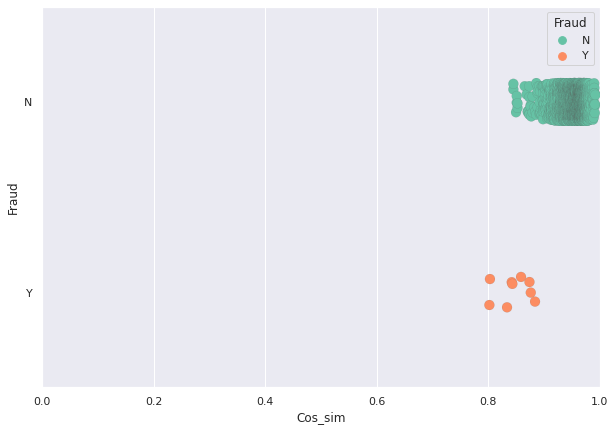

In [49]:
sns.set(rc={'figure.figsize':(10,7)})  
g = sns.stripplot(x='Cos_sim', y='Fraud', hue='Fraud', data=result_df[['Cos_sim','Fraud']], jitter=0.1, linewidth=0.1, palette="Set2", size=10,) 
g. set_xlim([0,1]) 